#### Imports

In [1]:
# Basic imports & versions
import sys, os, json, time, copy
import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt
import torch as th

# SB3
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor

# Utils and CityLearn
from utils.env_utils import keep_only_electrical_storage, keep_only_core_observations, PPOTrainLogger, DiscretizeActionWrapper
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-09-02 11:20:41.003208: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 11:20:41.016830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756804841.031536  771328 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756804841.035647  771328 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756804841.047245  771328 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1


#### Variables

In [2]:
# Configuration (kept consistent with other notebooks)
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/a2c'
EVAL_FILE = "a2c_eval_results.pkl"
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv'
ONLY_ELECTRICAL_STORAGE = True
EVAL_EPISODES = 10
ACTION_LABELS = ['100%_discharge','50%_discharge','idle','50%_charge','100%_charge']
NAME_TO_FRAC = {
    '100%_discharge': -1.0,
    '50%_discharge': -0.5,
    'idle': 0.0,
    '50%_charge': 0.5,
    '100%_charge': 1.0,
}
INT_TO_FRAC = np.array([NAME_TO_FRAC[n] for n in ACTION_LABELS], dtype=np.float32)

In [3]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN

# Set pricing file on all buildings
price_file = PRICING_FILE
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

# Narrow to electrical storage and core observations (same as other notebooks)
schema = keep_only_electrical_storage(schema)
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

# Keep only one building for Discrete(5)
one_building = "Building_1"
schema_1b = dict(schema)
schema_1b['buildings'] = {k: v for k, v in schema['buildings'].items() if k == one_building}
if not schema_1b['buildings']:
    raise RuntimeError(f"{one_building} not found in schema['buildings']")

# Create base env
env = CityLearnEnv(schema_1b, central_agent=True)

# Debug
print('Initial time step:', env.time_step)
print('Number of time steps:', env.time_steps)
print('Central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))
print('Electrical storage capacity:', {b.name: b.electrical_storage.capacity for b in env.buildings})
print('Action_space:', env.action_space)
print('Number of Observations:', len(env.observations[0]))

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-09-02_11-20-44'
Initial time step: 0
Number of time steps: 2208
Central agent: True
Number of buildings: 1
Electrical storage capacity: {'Building_1': 4.0}
Action_space: [Box(-1.0, 1.0, (1,), float32)]
Number of Observations: 6


In [14]:
# Build & Train A2C
os.makedirs(LOG_DIR, exist_ok=True)

train_env = NormalizedObservationWrapper(env)
train_env = StableBaselines3Wrapper(train_env)
train_env = DiscretizeActionWrapper(train_env, n_bins=5)   # Discrete(5): [-1,-0.5,0,0.5,1]
print('Train action_space:', train_env.action_space)       # should be Discrete(5)
train_env = Monitor(train_env, filename=os.path.join(LOG_DIR, "monitor.csv"))

logger = PPOTrainLogger()  # generic callback capturing ep_df/step stats

model = A2C(
    policy='MlpPolicy',
    env=train_env,
    learning_rate=0.0001,
    ent_coef=0.01,
    seed=0,
    verbose=1,
    policy_kwargs=dict(net_arch=[256, 256], activation_fn=th.nn.ReLU),
    # learning_rate=7e-4,  # default
    # n_steps=5, gae_lambda=1.0, gamma=0.99, ent_coef=0.0
)

TOTAL_TIMESTEPS = 2208 * 40

Train action_space: Discrete(5)
Using cuda device
Wrapping the env in a DummyVecEnv.


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [15]:
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=logger)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-start_time):.2f} seconds")
model.save("a2c_01")
print(f"A2C model saved to {os.path.abspath('a2c_01')}")

Total time elapsed for 88320 steps: 0.03 seconds
A2C model saved to /hkfs/home/haicore/iai/cj9272/a2c_01


In [16]:
# Check logger on training episodes
if hasattr(logger, 'ep_df') and len(logger.ep_df):
    ep_df = logger.ep_df
    first_n, last_n = 10, 10
    first_mean = ep_df['return'].head(first_n).mean()
    last_mean  = ep_df['return'].tail(last_n).mean()
    print(f'First {first_n} ep mean return: {first_mean:.3f}')
    print(f'Last  {last_n} ep mean return: {last_mean:.3f}')
    print('Learning indicator (last - first):', f'{(last_mean-first_mean):.3f}')
else:
    print('No episode returns in logger.ep_df')

No episode returns in logger.ep_df


#### Evaluation

In [17]:
schema_eval = copy.deepcopy(schema_1b)
eval_env = CityLearnEnv(schema_eval, central_agent=True)
eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)
eval_env = DiscretizeActionWrapper(eval_env, n_bins=5)

model = A2C.load("a2c_01")
print(f"A2C model loaded from {os.path.abspath('a2c_01')}")

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-09-02_11-34-21'
A2C model loaded from /hkfs/home/haicore/iai/cj9272/a2c_01


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
import pickle 
from citylearn.citylearn import CityLearnEnv

# Enhanced eval: collect actions/rewards and per-step obs series, optionally save to .pkl
def evaluate_with_metrics(model, env, episodes=5, deterministic=True, render=False, save_path=None):
    import pickle
    from citylearn.citylearn import CityLearnEnv

    def action_to_frac(env, action):
        if isinstance(env.action_space, gym.spaces.Discrete):
            return np.array([INT_TO_FRAC[int(action)]], dtype=np.float32)
        elif isinstance(env.action_space, gym.spaces.MultiDiscrete):
            a = np.asarray(action, dtype=int)
            return INT_TO_FRAC[a]
        else:
            return np.asarray(action, dtype=np.float32)

    def _get_base_env(e):
        cur, seen = e, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        raise RuntimeError("CityLearnEnv not found inside wrappers.")

    base = _get_base_env(env)
    bld_names = [b.name for b in base.buildings]
    building_name = "Building_1" if "Building_1" in bld_names else bld_names[0]
    b_idx = bld_names.index(building_name)

    obs_names = getattr(base, "observation_names", None)
    if obs_names is None:
        raise AttributeError("CityLearnEnv has no 'observation_names'.")
    obs_b = obs_names[b_idx]
    name_to_idx = {n: i for i, n in enumerate(obs_b)}
    i_net = name_to_idx.get("net_electricity_consumption")
    if i_net is None:
        i_net = name_to_idx.get("net_electricity_consumption_without_storage")
    i_nsl   = name_to_idx.get("non_shiftable_load")
    i_price = name_to_idx.get("electricity_pricing")
    i_solar = name_to_idx.get("solar_generation")

    ep_metrics, all_step_rewards, all_kpis, all_actions = [], [], [], []
    ep_lengths = []
    actions_disc_list, ep_action_fracs = [], []
    ep_rewards_list = []
    ep_net_load, ep_non_shiftable_load, ep_price, ep_solar_generation = [], [], [], []

    t_global_start = time.time()

    for ep in range(1, episodes + 1):
        obs, _ = env.reset()
        done = False
        ep_ret, ep_len = 0.0, 0
        step_rewards = []
        action_list = []

        ep_actions_disc = []
        ep_fracs = []
        ep_net, ep_nsl, ep_prc, ep_sol = [], [], [], []

        t_ep_start = time.time()
        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            frac = action_to_frac(env, action)
            action_list.append(frac)

            obs, r, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)

            # Discrete(5) single-building -> int id
            if isinstance(env.action_space, gym.spaces.Discrete):
                a_id = int(action)
            else:
                # Fallback: nearest bin for first dimension
                a_id = int(np.argmin(np.abs(INT_TO_FRAC - float(frac[0]))))

            ep_actions_disc.append(a_id)
            ep_fracs.append(float(INT_TO_FRAC[a_id]))
            ep_rewards = float(r)
            step_rewards.append(ep_rewards)
            ep_ret += ep_rewards
            ep_len += 1

            raw = base.observations[b_idx]
            ep_net.append(float(raw[i_net]) if i_net is not None else np.nan)
            ep_nsl.append(float(raw[i_nsl]) if i_nsl is not None else np.nan)
            ep_prc.append(float(raw[i_price]) if i_price is not None else np.nan)
            ep_sol.append(float(raw[i_solar]) if i_solar is not None else np.nan)

            if render:
                env.render()

        kpis = env.unwrapped.evaluate()
        all_kpis.append(kpis)
        all_actions.append(np.vstack(action_list))

        t_ep = time.time() - t_ep_start
        steps_per_sec = ep_len / max(t_ep, 1e-9)
        ep_metrics.append({
            'episode': ep, 'cumulative reward': ep_ret, 'length': ep_len,
            'mean_reward': ep_ret/ep_len if ep_len else np.nan,
            'min_step_reward': float(np.min(step_rewards)),
            'max_step_reward': float(np.max(step_rewards)),
            'std_step_reward': float(np.std(step_rewards)),
            'steps_per_sec': steps_per_sec, 'wall_time_s': t_ep
        })
        all_step_rewards.extend(step_rewards)

        # Store per-episode sequences
        ep_lengths.append(ep_len)
        actions_disc_list.append(np.asarray(ep_actions_disc, dtype=int))
        ep_action_fracs.append(np.asarray(ep_fracs, dtype=float))
        ep_rewards_list.append(np.asarray(step_rewards, dtype=float))
        ep_net_load.append(np.asarray(ep_net, dtype=float))
        ep_non_shiftable_load.append(np.asarray(ep_nsl, dtype=float))
        ep_price.append(np.asarray(ep_prc, dtype=float))
        ep_solar_generation.append(np.asarray(ep_sol, dtype=float))

        print(f"[Eval] Ep {ep}/{episodes} return={ep_ret:.3f} len={ep_len} "
              f"mean={ep_ret/ep_len:.3f} time={t_ep:.2f}s speed={steps_per_sec:.1f} steps/s")

    print(f"Total eval time: {time.time()-t_global_start:.2f}s  | Avg/ep: {(time.time()-t_global_start)/episodes:.2f}s")
    metrics_df = pd.DataFrame(ep_metrics)
    display(metrics_df)

    # Meta (align with DQN eval dict)
    price_file = schema['buildings'][building_name]['pricing']
    price_path = os.path.join(ROOT_DIR, price_file)
    prc_df = pd.read_csv(price_path)
    T = len(prc_df)

    results = {
        'ep_lengths': np.asarray(ep_lengths, dtype=int),
        'actions_disc_list': actions_disc_list,
        'step_rewards': np.asarray(all_step_rewards, dtype=float),

        'ep_action_fracs': ep_action_fracs,
        'ep_rewards_list': ep_rewards_list,
        'ep_net_load': ep_net_load,
        'ep_non_shiftable_load': ep_non_shiftable_load,
        'ep_price': ep_price,
        'ep_solar_generation': ep_solar_generation,

        'price_df': prc_df,
        'episode_len': T,
        'building_name': building_name,

        # A2C-specific extras
        'metrics_df': metrics_df,
        'episode_kpis': all_kpis,
    }

    if save_path is not None:
        with open(save_path, "wb") as f:
            pickle.dump(results, f)
        print(f"A2C eval results saved to {os.path.abspath(save_path)}")

    return metrics_df, np.array(all_step_rewards), all_kpis, all_actions

# Run eval and save
metrics_stoch, step_rewards_stoch, kpis_stoch, actions_stoch = evaluate_with_metrics(
    model, eval_env, episodes=EVAL_EPISODES, deterministic=False, save_path=EVAL_FILE
)

[Eval] Ep 1/10 return=-293.978 len=2207 mean=-0.133 time=116.66s speed=18.9 steps/s
[Eval] Ep 2/10 return=-294.728 len=2207 mean=-0.134 time=116.82s speed=18.9 steps/s
[Eval] Ep 3/10 return=-298.379 len=2207 mean=-0.135 time=117.35s speed=18.8 steps/s
[Eval] Ep 4/10 return=-295.700 len=2207 mean=-0.134 time=116.96s speed=18.9 steps/s
[Eval] Ep 5/10 return=-295.757 len=2207 mean=-0.134 time=117.19s speed=18.8 steps/s
[Eval] Ep 6/10 return=-297.329 len=2207 mean=-0.135 time=116.93s speed=18.9 steps/s
[Eval] Ep 7/10 return=-296.390 len=2207 mean=-0.134 time=117.50s speed=18.8 steps/s
[Eval] Ep 8/10 return=-297.106 len=2207 mean=-0.135 time=117.21s speed=18.8 steps/s
[Eval] Ep 9/10 return=-296.158 len=2207 mean=-0.134 time=117.70s speed=18.8 steps/s
[Eval] Ep 10/10 return=-294.010 len=2207 mean=-0.133 time=117.57s speed=18.8 steps/s
Total eval time: 1171.97s  | Avg/ep: 117.20s


,episode,cumulative reward,length,mean_reward,min_step_reward,max_step_reward,std_step_reward,steps_per_sec,wall_time_s
0,1,-293.977728,2207,-0.133202,-2.033061,0.0,0.174976,18.917750,116.662924
1,2,-294.727719,2207,-0.133542,-1.788633,0.0,0.174344,18.893000,116.815749
2,3,-298.378543,2207,-0.135196,-1.757477,0.0,0.174414,18.807023,117.349779
3,4,-295.699652,2207,-0.133983,-1.729649,0.0,0.173348,18.869264,116.962695
4,5,-295.756606,2207,-0.134008,-1.568949,0.0,0.174972,18.832389,117.191715
5,6,-297.328546,2207,-0.134721,-1.757477,0.0,0.178383,18.875275,116.925448
6,7,-296.390322,2207,-0.134296,-1.758275,0.0,0.176770,18.782370,117.503807
7,8,-297.106208,2207,-0.134620,-2.020118,0.0,0.179510,18.828916,117.213332
8,9,-296.157761,2207,-0.134190,-1.757477,0.0,0.176232,18.750915,117.700925
9,10,-294.009520,2207,-0.133217,-2.407078,0.0,0.172383,18.771265,117.573325


A2C eval results saved to /hkfs/home/haicore/iai/cj9272/a2c_eval_results.pkl


#### Plotting

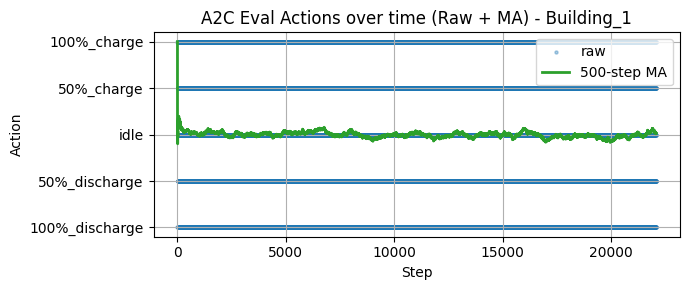

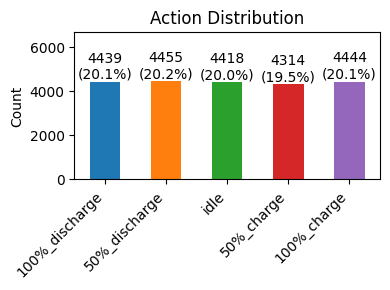

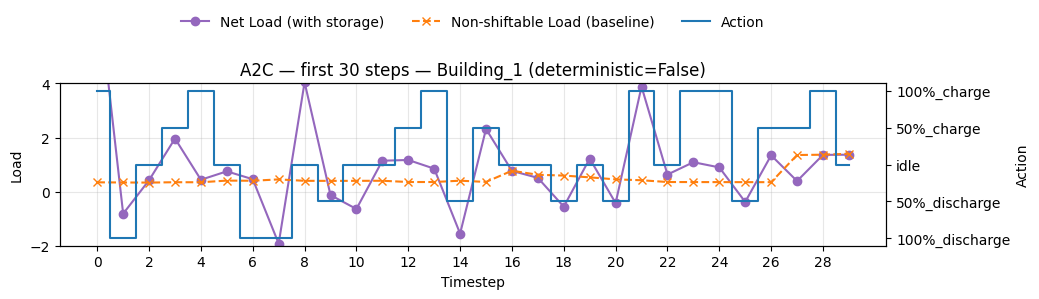

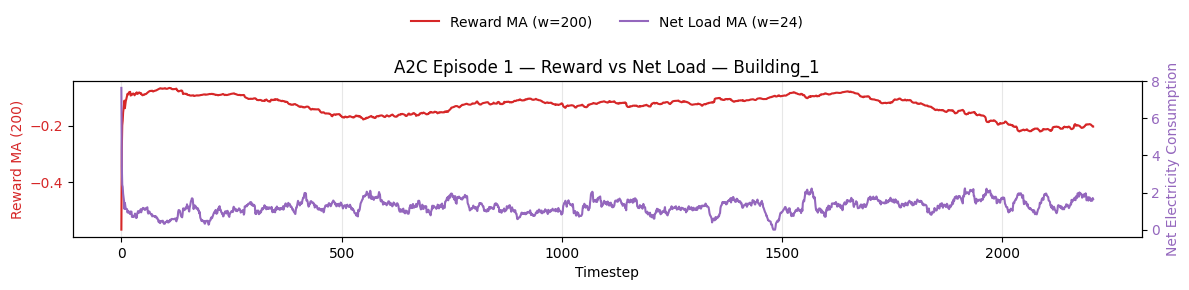

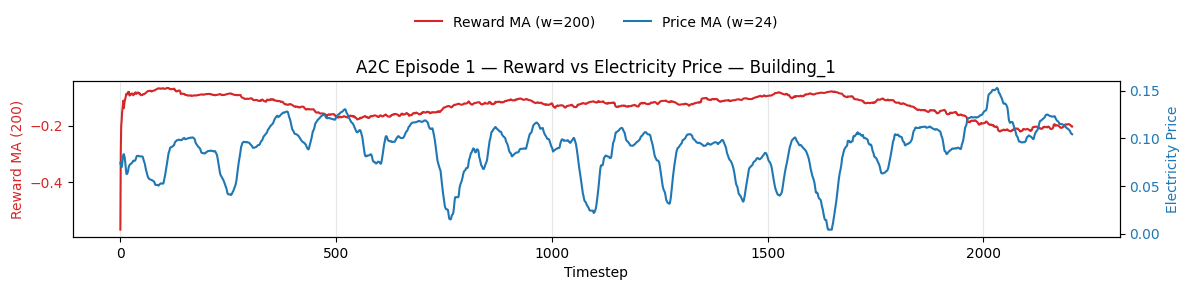

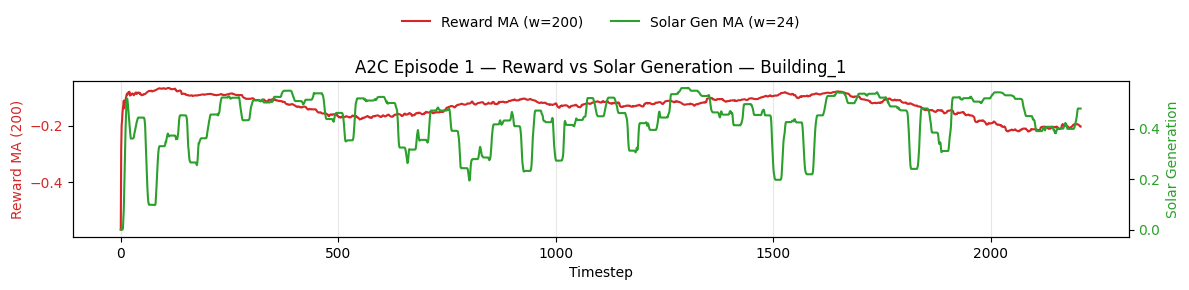

In [20]:
# ...existing code...
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from citylearn.citylearn import CityLearnEnv
from matplotlib.ticker import MultipleLocator

def _ensure_a2c_eval_results(path=EVAL_FILE):
    """Return cached A2C eval results if present; else load from file."""
    global er
    if 'er' in globals() and isinstance(er, dict):
        return er
    if os.path.exists(path):
        with open(path, "rb") as f:
            er = pickle.load(f)
        print(f"Eval results loaded from {os.path.abspath(path)}.")
        return er
    raise FileNotFoundError(f"{path} not found. Run evaluate_with_metrics(..., save_path=EVAL_FILE) first.")

# Load saved A2C eval to plot without re-evaluating
er = _ensure_a2c_eval_results()

# Rebuild vars expected by plots
# actions_stoch: list[(ep_len, n_actions)] -> here n_actions=1 (single building)
if 'ep_action_fracs' in er:
    actions_stoch = [np.asarray(ep, dtype=float)[:, None] for ep in er['ep_action_fracs']]
elif 'actions_disc_list' in er:
    actions_stoch = [INT_TO_FRAC[np.asarray(ep, dtype=int)][:, None] for ep in er['actions_disc_list']]
else:
    raise KeyError("No action sequences found in eval results.")

# metrics_stoch: DataFrame with at least 'length'
metrics_stoch = er.get('metrics_df', None)
if metrics_stoch is None or not isinstance(metrics_stoch, pd.DataFrame):
    ep_lengths = np.asarray(er.get('ep_lengths', [len(x) for x in actions_stoch]), dtype=int)
    metrics_stoch = pd.DataFrame({'episode': np.arange(1, len(ep_lengths)+1), 'length': ep_lengths})

# Prefer building name from file if present
building_name = er.get('building_name', 'Building_1')

def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

# (removed duplicate _ensure_a2c_eval_results definition below)
# ...existing code...

def capture_ep_series_a2c(building_name="Building_1", deterministic=True, max_steps=None, episode_idx=0):
    """Build per-step DataFrame from saved eval_results; no env stepping or model usage."""
    er = _ensure_a2c_eval_results()
    needed = [
        'ep_action_fracs', 'ep_rewards_list', 'ep_net_load',
        'ep_non_shiftable_load', 'ep_price', 'ep_solar_generation'
    ]
    missing = [k for k in needed if k not in er]
    if missing:
        raise ValueError(f"eval_results missing keys: {missing}. Re-run evaluate_with_metrics to regenerate.")
    n_eps = len(er['ep_rewards_list'])
    if not (0 <= episode_idx < n_eps):
        raise IndexError(f"episode_idx {episode_idx} out of range 0..{n_eps-1}")
    if 'actions_disc_list' in er and er['actions_disc_list'] and len(er['actions_disc_list']) > episode_idx:
        a_id = np.asarray(er['actions_disc_list'][episode_idx], dtype=int)
    else:
        frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
        a_id = np.argmin(np.abs(frac[:, None] - INT_TO_FRAC[None, :]), axis=1)
    a_frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
    rew    = np.asarray(er['ep_rewards_list'][episode_idx], dtype=float)
    net    = np.asarray(er['ep_net_load'][episode_idx], dtype=float)
    nsl    = np.asarray(er['ep_non_shiftable_load'][episode_idx], dtype=float)
    price  = np.asarray(er['ep_price'][episode_idx], dtype=float)
    solar  = np.asarray(er['ep_solar_generation'][episode_idx], dtype=float)
    L = len(rew)
    if max_steps is not None:
        L = min(L, int(max_steps))
        a_id, a_frac, rew, net, nsl, price, solar = (
            a_id[:L], a_frac[:L], rew[:L], net[:L], nsl[:L], price[:L], solar[:L]
        )
    df = pd.DataFrame({
        't': np.arange(L, dtype=int),
        'action_id': a_id,
        'action_frac': a_frac,
        'reward': rew,
        'net_load': net,
        'non_shiftable_load': nsl,
        'price': price,
        'solar_generation': solar,
    })
    return df, er.get('building_name', building_name)
# ...existing code...

def add_top_legend(ax_left, ax_right=None, ncol=3, y=1.50, top=0.84, loc='upper center', frameon=False):
    """Place a combined legend above the plot using lines from one or two axes."""
    handles = []
    for ax in (ax_left, ax_right):
        if ax is None:
            continue
        handles.extend(ax.get_lines())
    labels = [h.get_label() for h in handles]
    legend = ax_left.legend(handles, labels, loc=loc, bbox_to_anchor=(0.5, y), ncol=ncol, frameon=frameon)
    if top is not None:
        plt.subplots_adjust(top=top)
    return legend

# Choose a building to visualize
building_name = 'Building_1'
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if building_name not in bld_names:
    building_name = bld_names[0]
b_idx = bld_names.index(building_name)

# Flatten evaluated actions across episodes -> shape (total_steps, n_actions)
# actions_stoch is collected by evaluate_with_metrics (fractions in [-1,1])
actions_arr = np.concatenate(actions_stoch, axis=0)  # each item shape (ep_len, n_actions)
n_actions = actions_arr.shape[1]
total_steps = actions_arr.shape[0]

# Build episode boundaries from metrics
ep_lengths = metrics_stoch['length'].to_numpy()
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
hour_index = np.arange(total_steps)

# Load pricing for the chosen building
price_file = schema['buildings'][building_name]['pricing']
price_path = os.path.join(ROOT_DIR, price_file)
prc = pd.read_csv(price_path)
T = len(prc)  # 2208

# Helper: map continuous action to 5 labels by nearest of [-1,-0.5,0,0.5,1]
def frac_to_label_idx(vals: np.ndarray) -> np.ndarray:
    return np.argmin(np.abs(vals[..., None] - INT_TO_FRAC[None, :]), axis=-1)


# ----- Plot 1: Actions over Time (for selected building) -----
window = 500
act_series = actions_arr[:, b_idx]
act_ma = pd.Series(act_series).rolling(window, min_periods=1).mean().to_numpy()

plt.figure(figsize=(7,3))
plt.scatter(hour_index, act_series, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'{window}-step MA')
plt.title(f'A2C Eval Actions over time (Raw + MA) - {building_name}')
plt.xlabel('Step'); plt.ylabel('Action'); plt.grid(True); plt.legend(loc='upper right')
plt.yticks(ticks=INT_TO_FRAC.tolist(), labels=ACTION_LABELS)
plt.tight_layout(); plt.show()


# ----- Plot 2: Action Distribution (quantized to 5 bins like RBC) -----
plt.figure(figsize=(4,3))
labels_idx = frac_to_label_idx(act_series)
counts = pd.Series(labels_idx).value_counts().reindex(range(5)).fillna(0).astype(int)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()


def plot_first_30_steps_actions_vs_loads_a2c(building_name="Building_1", deterministic=True):
    """Plot first 30 steps: net load vs non-shiftable load with action (discrete bins in [-1..1])."""
    df30, bname = capture_ep_series_a2c(building_name, deterministic=deterministic, max_steps=30)

    t = df30['t'].to_numpy()
    net = df30['net_load'].to_numpy()
    nsl = df30['non_shiftable_load'].to_numpy()
    act = df30['action_frac'].to_numpy()

    fig, ax1 = plt.subplots(figsize=(10.5, 3.6))
    ax1.plot(t, net, color='C4', marker='o', label='Net Load (with storage)')
    ax1.plot(t, nsl, color='C1', ls='--', marker='x', label='Non-shiftable Load (baseline)')
    ax1.set_xlabel('Timestep')
    ax1.set_xticks(t[::2])
    ax1.set_ylabel('Load')
    ax1.set_ylim(-2, 4)  # enforce requested load range
    ax1.yaxis.set_major_locator(MultipleLocator(2))  # enforce ticks every 2 units
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.step(t, act, where='mid', color='C0', label='Action')
    ax2.set_ylabel('Action')
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_yticks(INT_TO_FRAC.tolist())
    try:
        ax2.set_yticklabels(ACTION_LABELS)
    except Exception:
        ax2.set_yticklabels(['100%_discharge','50%_discharge','idle','50%_charge','100%_charge'])
    add_top_legend(ax1, ax2)
    plt.title(f'A2C — first 30 steps — {bname} (deterministic={deterministic})')
    plt.tight_layout()
    plt.show()

def plot_ep1_reward_vs_obs_a2c(building_name="Building_1", deterministic=True):
    """Three plots: Reward vs Price, Solar, Net for episode 1."""
    df, bname = capture_ep_series_a2c(building_name, deterministic=deterministic, max_steps=None)

    window_reward = 200
    window_x = 24
    t = df['t'].to_numpy()
    reward_ma = pd.Series(df['reward']).rolling(window_reward, min_periods=1).mean().to_numpy()
    price_ma  = pd.Series(df['price']).rolling(window_x, min_periods=1).mean().to_numpy()
    solar_ma  = pd.Series(df['solar_generation']).rolling(window_x, min_periods=1).mean().to_numpy()
    net_ma    = pd.Series(df['net_load']).rolling(window_x, min_periods=1).mean().to_numpy()

    # 4) Reward vs Net Load
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, net_ma, color='C4', label=f'Net Load MA (w={window_x})')
    ax2.set_ylabel('Net Electricity Consumption', color='C4'); ax2.tick_params(axis='y', labelcolor='C4')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'A2C Episode 1 — Reward vs Net Load — {bname}')
    plt.tight_layout(); plt.show()

    # 5) Reward vs Electricity Price
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, price_ma, color='C0', label=f'Price MA (w={window_x})')
    ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'A2C Episode 1 — Reward vs Electricity Price — {bname}')
    plt.tight_layout(); plt.show()

    # 6) Reward vs Solar Generation
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, solar_ma, color='C2', label=f'Solar Gen MA (w={window_x})')
    ax2.set_ylabel('Solar Generation', color='C2'); ax2.tick_params(axis='y', labelcolor='C2')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'A2C Episode 1 — Reward vs Solar Generation — {bname}')
    plt.tight_layout(); plt.show()


# ----- Plot 3: Actions vs Loads (first 30 steps) -----
plot_first_30_steps_actions_vs_loads_a2c(building_name="Building_1", deterministic=False)


# ----- Plot 4,5,6: Actions vs Observations(Net Load, Price, Solar Generation) - first episode -----
plot_ep1_reward_vs_obs_a2c(building_name="Building_1", deterministic=False)